<img src=images/Stöwer_Titanic.jpg align="right" width="15%" style="margin-right:10%">

#### August 18, 2016 - Women in Data Science ATX Meetup - "Data Science from Scratch" Workshop #6

# Hypothesis Testing on the Titanic Data Set with R

## 0. Preliminaries

### 0.1 Set up the R language kernel for Jupyter + load libraries
https://www.continuum.io/blog/developer/jupyter-and-conda-r

#### Assumption:
You have Anaconda installed. If not, go here for instructions:  
https://github.com/mGalarnyk/Installations_Mac_Ubuntu_Windows

#### Summary:
1. Open a shell and run this command to install `r-essentials` into the current environment:
<pre><code>conda install -c r r-essentials
</code></pre>
OR, run this command to install it into a new environment:
<pre><code>conda create -n my-r-env -c r r-essentials
</code></pre>
2. Start a new jupyter notebook session:
<pre><code>jupyter notebook</code></pre>

#### Note:
Beware that you may sometimes get traceback (error) messages that print one character per line, i.e., vertically. It looks like this bug has been fixed:  
https://github.com/IRkernel/IRkernel/issues/261

However, the date on the fix is later than the date of the latest release, IRkernel 0.6.1, so we'll just live with it for now:  
https://github.com/IRkernel/IRkernel/releases

In [2]:
# Load libraries
library(ggplot2) # visualization
library(dplyr)   # data manipulation
library(repr)    # used only to change default figure size

# Change figure size to 6 x 4
options(repr.plot.width=6, repr.plot.height=4)

### 0.2 Resources
- *(DS From Scratch)* [Data Science From Scratch](http://shop.oreilly.com/product/0636920033400.do) - Chapter 7: Hypothesis and Inference
- *(OIS)* "OpenIntro Statistics" book: https://www.openintro.org/stat/textbook.php?stat_book=os - Chapter 4: Foundations for Inference
- *(PPA)* "Practical Predictive Analytics: Models and Methods" course: (https://www.coursera.org/learn/predictive-analytics/home/week/1) - Week 1: Practical Statistical Inference  
- *(Wikipedia)*: https://en.wikipedia.org/wiki/Statistical_hypothesis_testing

Some text taken directly from:
- *(IS)* "Inferential Statistics" course: https://www.coursera.org/learn/inferential-statistics-intro/

Some code taken directly from:
- https://www.analyticsvidhya.com/blog/2015/10/inferential-descriptive-statistics-beginners-r/
- https://choens.github.io/titanic-workshop/03-eda-and-hypothesis-testing.html
- https://rpubs.com/jeffrey6557/52266

The files `train.csv` and `test.csv` were downloaded from https://www.kaggle.com/c/titanic/data.

### 0.3 Overview
Our goal in this workshop is to work through a hypothesis test on the same Titanic dataset that we've worked with in previous workshops. The Titanic data comes to us already having been randomly sampled into two files `train.csv` and `test.csv`. However, the file `test.csv` is unlabeled, so we won't use it unless we want to look at distributions of variables over the entire set of passenger data. 

We will be considering a *sample* from the *population* of all Titanic passengers (not including crew members). There were approximately [1317 passengers](http://www.titanicfacts.net/titanic-passengers.html) on board the Titanic when it sank.

We'll follow a general set of steps for statistical hypothesis testing.

## 1. Set the hypotheses
"The first step is to state the relevant null and alternative hypotheses. This is important, as mis-stating the hypotheses will muddy the rest of the process." - *Wikipedia*

Here are some examples of general hypotheses:
- "This coin is fair."
- "Data scientists prefer Python to R."
- "People are more likely to navigate away from the page without ever reading the content if we pop up an irritating interstitial advertisement with a tiny, hard-to-find close button."

\- *DS From Scratch*

Next, express the hypothesis you want to investigate as:
- a **null hypothesis** $H_0$ that represents some default position, and
- an **alternative hypothesis** $H_A$ that we'll compare $H_0$ with.

Another way to think of this is that we want to compare an experimental group and a control group. Stated this way:
- the **null hypothesis** claims that there is no difference between the groups, and
- the **alternative hypothesis** claims that there is a statistically significant difference between the groups.

### *Example:* Consider `Age` variable of Titanic data set
We've heard that women and children were asked to get on the lifeboats first when the Titanic was sinking. So let's investigate the general hypothesis that children aboard the Titanic had a better chance of survival than adults. Did they?

To answer this we can do a hypothesis test comparing two proportions: the proportion of children who survived, $p_{\rm child}$, and the proportion of adults who survived, $p_{\rm adult}$. We can state the null and alternative hypotheses as:
- $H_0$: $p_{\rm child} - p_{\rm adult} = 0$ There is no significant difference in the proportion of children who survive and the proportion of adults who survive.
- $H_A$: $p_{\rm child} - p_{\rm adult} > 0$ There is a better chance of survival for children than adults.

$p_{\rm child}$ is our unknown population proportion of children who survived  
$p_{\rm adult}$ is our unknown population proportion of adults who survived

Our *parameter of interest* is the difference between the proportions of **all** Titanic child passengers and **all** Titanic adult passengers who survived: $p_{\rm child} - p_{\rm adult}$.

Our *point estimate* is the difference between the proportions of **sampled** Titanic child passengers and **sampled** Titanic adult passengers who survived: $\hat{p}_{\rm child} - \hat{p}_{\rm adult}$.

## 2. Check assumptions and conditions
"The second step is to consider the statistical assumptions being made about the sample in doing the test; for example, assumptions about the statistical independence or about the form of the distributions of the observations. This is equally important as invalid assumptions will mean that the results of the test are invalid." - *Wikipedia*

In hypothesis testing the "control" and "experimental" groups are typically defined through careful experimental design. This is not usually the case in data science applications, though. An exception is collecting click-through data in an A/B test that measures the effect of new ad placement on your website compared to the control group, or existing placement. - *PPA*

#### First, some notes on estimating the difference between the population parameter of interest (and between the point estimate):

To estimate the difference between the two proportions, look at the *point estimate* $\pm$ the *margin of error*:
$$(\hat{p}_{\rm child} - \hat{p}_{\rm adult}) \pm z^*\,\textrm{SE}_{\hat{p}_{\rm child} - \hat{p}_{\rm adult}},$$

where $z^*$ is the critical $z$-score. We're using this because based on the *Central Limit Theorem* our proportions (and their differences) are going to be nearly normal.

This is how we calculate the standard error for the difference between two proportions that we'll need for calculating a *confidence interval*:

$$\textrm{SE} = \sqrt{\frac{\hat{p}_{\rm child}(1 - \hat{p}_{\rm child})}{n_{\rm child}} + \frac{\hat{p}_{\rm adult}(1 - \hat{p}_{\rm adult})}{n_{\rm adult}}}$$

Note that the standard error is basically just the standard deviation of the *sampling distribution*.

#### Check the conditions for inference for comparing two independent proportions:
1. *Independence:*
    - **within groups**: sampled observations must be independent within each group
        - random sample/assignment
        - if sampling without replacement, $n < 10$% of population
    - **between groups**: the two groups must be independent of each other (non-paired)
    
2. *Sample size/skew:* Each sample should meet the success-failure condition:
    $$n_{\rm child} p_{\rm child} \ge 10 \quad \textrm{and} \quad n_{\rm child} (1 - p_{\rm child}) \ge 10$$
    $$n_{\rm adult} p_{\rm adult} \ge 10 \quad \textrm{and} \quad n_{\rm adult} (1 - p_{\rm adult}) \ge 10$$
    
Note that for calculating the *confidence interval* we need to use the "p-hat" values corresponding to the observed sample proportions.

Using a 95% confidence interval, let's estimate how the proportion of children who survived the Titanic shipwrech compares to the proportion of adults.

1. Check *independence*: 
    - check **within groups**:
        - the sample should be random for both adults and children since we either take the data from `train.csv` and work with that, or randomly sample the data ourselves.
        - to meet the 10% condition we need to estimate how many children and how many adults are in the *population* of Titanic passengers.
      
So, let's take a look at the Titanic data, then continue with our checks.

#### Load the Titanic training data set:

In [3]:
train <- read.csv("data/train.csv")  # read in Titanic training data csv file to R data frame
str(train)                           # display data frame using R `str` function

'data.frame':	891 obs. of  12 variables:
 $ PassengerId: int  1 2 3 4 5 6 7 8 9 10 ...
 $ Survived   : int  0 1 1 1 0 0 0 0 1 1 ...
 $ Pclass     : int  3 1 3 1 3 3 1 3 3 2 ...
 $ Name       : Factor w/ 891 levels "Abbing, Mr. Anthony",..: 109 191 358 277 16 559 520 629 417 581 ...
 $ Sex        : Factor w/ 2 levels "female","male": 2 1 1 1 2 2 2 2 1 1 ...
 $ Age        : num  22 38 26 35 35 NA 54 2 27 14 ...
 $ SibSp      : int  1 1 0 1 0 0 0 3 0 1 ...
 $ Parch      : int  0 0 0 0 0 0 0 1 2 0 ...
 $ Ticket     : Factor w/ 681 levels "110152","110413",..: 524 597 670 50 473 276 86 396 345 133 ...
 $ Fare       : num  7.25 71.28 7.92 53.1 8.05 ...
 $ Cabin      : Factor w/ 148 levels "","A10","A14",..: 1 83 1 57 1 1 131 1 1 1 ...
 $ Embarked   : Factor w/ 4 levels "","C","Q","S": 4 2 4 4 4 3 4 4 4 2 ...


The training data set is a random sample of 891 passengers from the total 1309 passengers in our data set. This is over 67% of all 1317 passengers aboard the Titanic when it sank. 

In [40]:
# # UNCOMMENT TO LOOK AT FULL SET OF DATA - THE ENTIRE POPULATION
# test  <- read.csv('data/test.csv')   # read in Titanic test data csv file

# training <- data.frame(train$Age, train$Sex, train$Pclass);  # disclude Survived and assign to new data frame so we don't lose "train"
# names(training) <- c("Age", "Sex","Pclass"); # rename column variables
# names(test)  <- c("Age", "Sex","Pclass");

# full  <- bind_rows(training, test)      # bind training & test data
# str(full)  # note that there are 1309 observations, which is over 99% of the entire population of 1317

There are 12 columns, but we will subset the data to just a few columns of interest:
- 1 numerical: `Age`
- 3 categorial: `Pclass`, `Sex`, `Survived`

In [4]:
train <- data.frame(train$Survived, train$Age, train$Sex, train$Pclass); # select 4 columns of data frame
names(train) <- c("Survived", "Age", "Sex","Pclass"); # rename columns from, e.g., train$Survived to Survived
head(train) # display first 6 rows of data frame

,Survived,Age,Sex,Pclass
1,0,22,male,3
2,1,38,female,1
3,1,26,female,3
4,1,35,female,1
5,0,35,male,3
6,0,NA,male,3


The training data set contains age data on ~80% of the passengers in this sample (714 / 891):

In [6]:
str(train[!is.na(train$Age),])

'data.frame':	714 obs. of  4 variables:
 $ Survived: int  0 1 1 1 0 0 0 1 1 1 ...
 $ Age     : num  22 38 26 35 35 54 2 27 14 4 ...
 $ Sex     : Factor w/ 2 levels "female","male": 2 1 1 1 2 2 2 1 1 1 ...
 $ Pclass  : int  3 1 3 1 3 1 3 3 2 3 ...


#### Let's drop rows without `Age` values:

In [7]:
# Let's keep the data frame "train" intact for later use, and create a new one called "train_age"
train_age <- train[!is.na(train$Age),] # strip "train" data of rows with Age=NULL
summary(train_age$Age)                 # show some descriptive statistics of Age variable

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.42   20.12   28.00   29.70   38.00   80.00 

This reduces our sample size to 714 observations, a little over 54% (714 / 1317) of the population. This may reduce the randomness of our sample since passengers missing age data may not have been randomly selected for discluding this information.

The youngest passenger in this sample was 5 months old and the oldest was 80 years old, which seems quite a bit older than the average life expectancy of early to mid 50s for the year 1912 when the Titanic sank: http://demog.berkeley.edu/~andrew/1918/figure2.html

#### Let's take a look at the distribution of passenger ages:

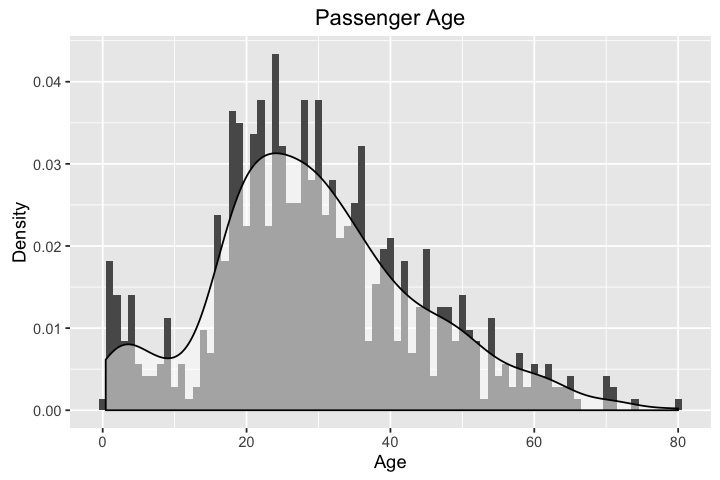

In [8]:
# Overlay a probability distribution function (PDF) on a histogram of Age
ggplot(train_age, aes(x=Age)) + 
    ggtitle("Passenger Age") + 
    xlab("Age") + 
    ylab("Density") + 
    geom_histogram(aes(y=..density..), binwidth=1)+
    geom_density(alpha=.5, fill="#FFFFFF")

We can see the discrepancies at extreme ages with a normal quantile plot. The data is noticeably right-skewed, although there is clear dip in the number of pre-teen and teenage passengers. 

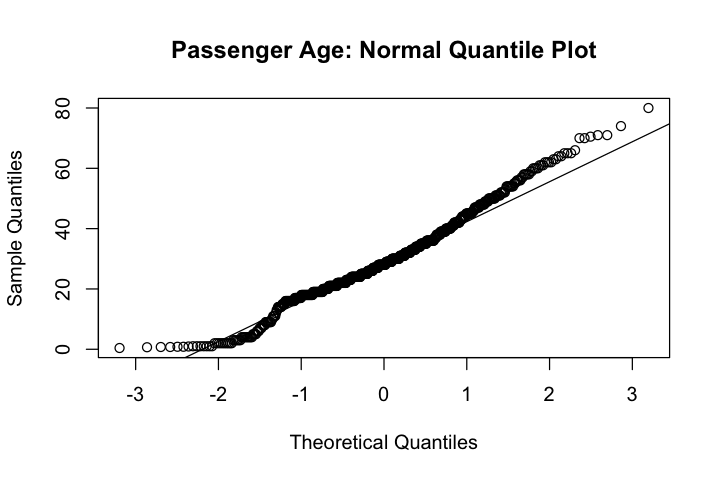

In [9]:
qqnorm(train_age$Age, main="Passenger Age: Normal Quantile Plot")
qqline(train_age$Age)

### 2.1 Independence: 
- random sample/assignment 
- 10% condition when sampling without replacement

### 2.2 Sample size/skew:
- $n \ge 30$ (or larger if sample is skewed)
- no extreme skew

### 2.3 Interrelationship between independence and sample size/skew

Now let's discretize the ages into two groups - adults and children. We'll choose 18 years old as the minimum age for an adult. There are 113 children in the data set:

In [10]:
length(which(train_age$Age < 18))

[1] 113

In [11]:
# Add a new categorical variable called "AgeGroup" with values "Child" or "Adult".
train_age$AgeGroup <- "Adult"
train_age$AgeGroup[train_age$Age < 18] <- "Child"

In [16]:
# Add a new categorical variable called "Lived" with "Yes" or "No" instead of "1" or "0" for Survival.
train_age$Lived[ train_age$Survived == 1 ] <- "Yes"
train_age$Lived[ train_age$Survived == 0 ] <- "No"

# Return a contingency table of the new Lived column.
lived <- table( train_age$Lived )
lived


 No Yes 
424 290 

In [17]:
# Create a contingency table with proportions.
percent_lived <- round( 100*prop.table( lived ), 2 )
percent_lived


   No   Yes 
59.38 40.62 

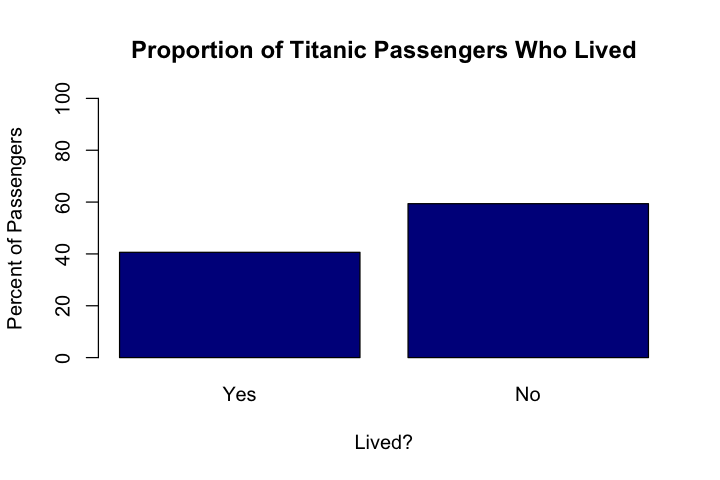

In [18]:
## Plots the lived proportions. Now fancier!
## Reverses Yes and No
## Labels the graph and the axes.
## Colors Output
## And adjusts the Y limit.
barplot(sort(percent_lived, decreasing=FALSE),
        main="Proportion of Titanic Passengers Who Lived",
        xlab="Lived?", 
        ylab="Percent of Passengers",
        col="darkblue",
        ylim=c(0,100)
        )

#### Let's display a contingency table of child/adult survival:
We see that 54% of children and only 38% of adults survive. But the child population is much smaller than the adult one. 

In [19]:
# `table` creates a contingency table
age_group_lived <- table(train_age$AgeGroup, train_age$Lived)
age_group_lived

       
         No Yes
  Adult 372 229
  Child  52  61

In [22]:
# `prop.table` gives the row percentages
age_group_lived_prop <- prop.table(age_group_lived, margin=1) # 1 = rows, 2 = columns
age_group_lived_prop

       
               No       Yes
  Adult 0.6189684 0.3810316
  Child 0.4601770 0.5398230

## 3. Calculate a *test statistic* and a $p$-value (draw a picture!) 

$$Z = \frac{\bar{x} − \mu}{\textrm{SE}},$$
where $$\textrm{SE} = \frac{s}{\sqrt{n}}$$

"Compute from the observations the observed value of the test statistic." - *Wikipedia*

"Calculate the $p$-value. This is the probability, under the null hypothesis, of sampling a test statistic at least as extreme as that which was observed." - *Wikipedia*

Our *test statistic* will be the proportion of passengers who survived. So the *population parameter* of interest is
$$\pi = \frac{N_{\rm survived}}{N},$$ 
where $N=1317$ is the total number of passengers in the population of all fare-paying Titanic passengers and $N_{\rm survived} = $. We'll call the proportion $\pi$ for the population parameter and $pi$ for the sample statistic.

In [39]:
290 / (290+424)
571 / 670
0.41 + 1.96 * sqrt(0.41 * 0.59 / 714)
1.96 * sqrt(0.41 * 0.59 / 714)

[1] 0.4061625

[1] 0.8522388

[1] 0.4460765

[1] 0.03607654

#### Is the difference in survival rates significant? Let's see with a permutation test:

In [23]:
## Hypothesis: Children are more likely to survive.
## Run prop.test against the values, NOT the proportions.
prop.test(age_group_lived, alternative = "greater")


	2-sample test for equality of proportions with continuity correction

data:  age_group_lived
X-squared = 9.2961, df = 1, p-value = 0.001148
alternative hypothesis: greater
95 percent confidence interval:
 0.06981213 1.00000000
sample estimates:
   prop 1    prop 2 
0.6189684 0.4601770 


- The p-value is less that 0.05, so we can reject the null hypothesis.
- Yes children were more likely to survive.
- When passed a contingency table, R will calculate greater/less based on the FIRST COLUMN. Adjust your hypothesis accordingly.

In [24]:
## The summary() function can be used
## to examine most R objects.
summary(age_group_lived)

Number of cases in table: 714 
Number of factors: 2 
Test for independence of all factors:
	Chisq = 9.944, df = 1, p-value = 0.001614

In [27]:
summary(train_age)

    Survived           Age            Sex          Pclass     
 Min.   :0.0000   Min.   : 0.42   female:261   Min.   :1.000  
 1st Qu.:0.0000   1st Qu.:20.12   male  :453   1st Qu.:1.000  
 Median :0.0000   Median :28.00                Median :2.000  
 Mean   :0.4062   Mean   :29.70                Mean   :2.237  
 3rd Qu.:1.0000   3rd Qu.:38.00                3rd Qu.:3.000  
 Max.   :1.0000   Max.   :80.00                Max.   :3.000  
   AgeGroup            Lived          
 Length:714         Length:714        
 Class :character   Class :character  
 Mode  :character   Mode  :character  
                                      
                                      
                                      

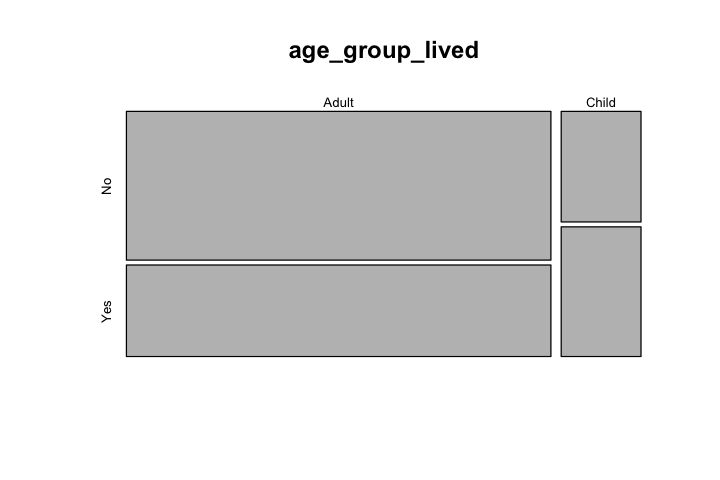

In [25]:
## The mosaicplot is another way of visualizing
## complex relationships and can scale effectively
## for many variables.
mosaicplot(age_group_lived)

In [ ]:
adult_survival <- age_group_survived.prop[3]
child_survival <- age_group_survived.prop[4]
observed <-  child_survived / adult_survived
observed # children are nearly 1.42x more likely to survive 

In [ ]:
N=10^4-1 ; result <- numeric(N)  
for (i in 1:N) {
    index <- sample(nrow(train), size=154, replace=FALSE)
    child_sample <- length(which(train$Survived[index] == 1)) / length(index)
    adult_sample <- length(which(train$Survived[-index] == 1)) / (nrow(train) - length(index))
    result[i] <- child_sample / adult_sample 
}

In [ ]:
qplot(result, binwidth=.05) + 
    geom_vline(xintercept = observed, color="red") +#, label="Observed") +
    ggtitle("Permutation Test: Child Survival / Adult Survival") + 
    xlab("Ratio") + 
    ylab("Count")

In [ ]:
pvalue = (sum (result >= observed) + 1)/(N+1); 
2 * pvalue 

## 4. Make a decision, and interpret it in the context of the research question
"Reject the null hypothesis, in favor of the alternative hypothesis, if and only if the `p`-value is less than the significance level (the selected probability) threshold." - *Wikipedia*

- If $p$-value $< \alpha$, reject $H_0$, data provide evidence for $H_A$
- If $p$-value $> \alpha$, do not reject $H_0$, data do not provide evidence for $H_A$

A near-zero p-value indicates that the evidence supports the alternative hypothesis that children are more likely to have survived.

So, we should **reject the null hypothesis**.

There's only a 0.1% chance you'd observe such an extreme statistic if our null hypothesis were true.

|                    | Do Not Reject $H_0$                   | Reject $H_0$                         |
|--------------------|:-------------------------------------:|:------------------------------------:|
| **$H_0$ is True**  | *Correct Decision*<br>($1 - \alpha$)  | *Type 1 Error*<br>($\alpha$)         |
| **$H_0$ is False** | *Type 2 Error*<br> ($\beta)$          | *Correct Decision*<br> ($1 - \beta)$ |

## EXERCISE TIME!
Now try working through hypothesis testing on `Pclass` or `Sex`!

### *Exercise:* Consider `Pclass` (passenger class) variable
Next we could look at whether upper class passengers aboard the Titanic had a better chance of survival than lower class passengers. We would compare the proportion of upper class passengers who survived, $p_{\rm upper}$, with the proportion of lower class passengers, $p_{\rm lower}$.
- $H_0$: $p_{\rm upper} - p_{\rm lower} = 0$ There is no significant difference in the chances of survival of upper and lower class passengers.
- $H_A$: $p_{\rm upper} - p_{\rm lower} > 0$ There is a better chance of survival for upper class passengers. 

If you need ideas, check this blog post:
https://www.analyticsvidhya.com/blog/2015/10/inferential-descriptive-statistics-beginners-r/

### *Exercise:* Consider `Sex` variable
- Q1: Create a 2x2 Contingency table for Lived and Sex. Call it `sex_survival`.
- Q2: What is the proportion of men who lived, compared to proportion of women?
- Q3: Is the observed difference between the sexes in the survival rate statistically significant?

## Final Comments


"To do good *science*:"
>- Determine your hypotheses before looking at the data.
>- Clean your data without the hypotheses in mind.
>- Keep in mind that $p$-values are not substitutes for common sense.

- *DS From Scratch*

## More Resources
- http://gchang.people.ysu.edu/class/s5817/L/ReviewNote_5817.pdf
- https://www.encyclopedia-titanica.org/
- https://en.wikipedia.org/wiki/Resampling_(statistics)
- https://lagunita.stanford.edu/courses/HumanitiesScience/StatLearning - Chapter 5: Resampling Methods
- http://www.nature.com/news/scientific-method-statistical-errors-1.14700
- https://ds8.gitbooks.io/textbook/content/chapter5/intro.html
- [Statistics for Hackers](https://www.youtube.com/watch?v=Iq9DzN6mvYA) - PyCon 2016 talk by Jake Vanderplas

The notebook `2016-08-18-TitanicHypothesisTesting-python.ipynb` in this repository is the start of a translation of the current notebook in `R` to `Python`. If you'd like to help complete the translation, please fork the repository, make your changes, and issue a pull request!

Thanks for coming!